In [268]:
%%capture
# load the data into two raws and datasets ( capture - do not print to screen)

# files1 = glob('/Users/shiran/workspace/muse-lsl/data/visual/P300/shiran/muse_monitor_dogs/data_2017-07-29-13.09.47.csv')
# files2 = glob("/Users/shiran/workspace/muse-lsl/data/visual/P300/shiran/muse_monitor_dogs/data_2017-07-29-10.09.16.csv" )
# monitor = glob("/Users/shiran/workspace/muse-lsl/data/visual/P300/shiran/muse_monitor_dogs/data_2017-07-29-13.21.06.csv" )
monitor = glob("/Users/shiran/workspace/muse-lsl/data/visual/P300/shiran/muse_monitor_dogs/*.csv" )

muse = glob('/Users/shiran/workspace/muse-lsl/data/visual/P300/subject1/session1/*.csv')
# files2 = glob("/Users/shiran/workspace/muse-lsl/data/visual/P300/shiran/dogs/data_2017-07-29-09.26.*.csv" )

raw1 = get_raw(muse)
raw2 = get_raw(monitor)

df1 = raw1.to_data_frame()
df2 = raw2.to_data_frame()


event_id = {'Non-Target': 1, 'Target': 2}
reject = {'eeg': 100e-6}
avg1, epochs1 = clean_epochs(event_id, raw1,{'start': 1,'end': 30}, None)
avg2, epochs2 = clean_epochs(event_id, raw2, {'start': 1,'end': 30}, reject)

In [269]:
from IPython.display import display
# display(df1.tail(10))
# display(df1[df1.Stim==1].describe())
print("\033[35mmsubject 1 / session 1\x1b[0m")
display(df1.describe())
print("\033[35mdata from muse monitor")
display(df2.describe())

msubject 1 / session 1


signal,TP9,AF7,AF8,TP10,Stim
count,184392.000000,184392.000000,184392.000000,184392.000000,184392.000000
mean,0.004031,0.002873,0.003809,0.006216,0.007300
std,0.005326,0.000531,0.001763,0.001169,0.096193
min,-0.030908,-0.003906,-0.100000,-0.016309,0.000000
25%,-0.000879,0.002539,0.003320,0.005469,0.000000
50%,0.004297,0.002881,0.003809,0.006201,0.000000
75%,0.008887,0.003174,0.004297,0.006982,0.000000
max,0.025488,0.017822,0.099951,0.024756,2.000000


data from muse monitor


signal,TP9,AF7,AF8,TP10,Stim
count,60864.000000,60864.000000,60864.000000,60864.000000,60864.000000
mean,846.761442,847.506280,843.916620,845.978137,0.006786
std,56.442193,16.648986,11.424676,41.060488,0.089009
min,609.634000,202.271000,749.451000,595.531000,0.000000
25%,796.190000,844.139000,842.125000,807.473000,0.000000
50%,844.139000,849.780000,846.557000,844.139000,0.000000
75%,898.132000,854.212000,850.183000,884.835000,0.000000
max,1002.088000,893.297000,883.223000,1065.348000,2.000000


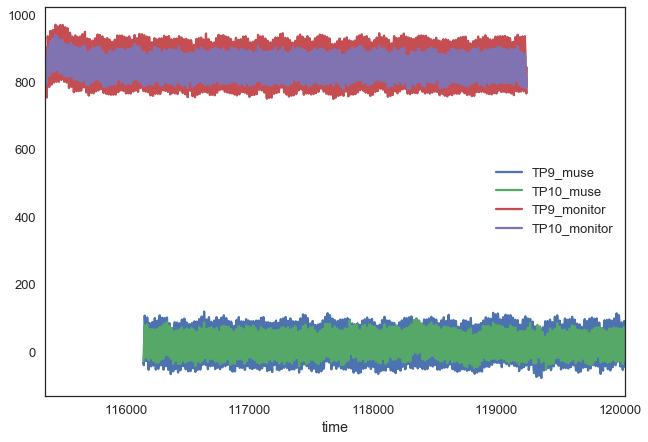

In [218]:
# plt.hist(df2['TP9'])
# plt.hist(df1['TP9'])

# plt.figure()
# df2.plot()
# plt.show()

muse_df = df1[['TP9','TP10']].tail(1000)
muse_df.columns  = ['TP9_muse','TP10_muse']
monitor_df = df2[['TP9','TP10']].tail(1000)
monitor_df.columns  = ['TP9_monitor','TP10_monitor']

both = pd.concat([muse_df,monitor_df],axis=1)

both.plot()
plt.show()
# df1.tail(100).describe()

In [ ]:
from IPython.display import display
raw_data_uncliean=get_raw( files2)
#beofre cleaning
raw_data=get_raw(files2)
raw_data.filter(1,30)
display(raw_data.to_data_frame().describe())
display(raw_data_uncliean.to_data_frame().describe())

In [ ]:
display(raw1.plot_psd(tmax=np.inf))
raw2.plot_psd(tmax=np.inf)

In [ ]:
avg1.plot()
avg1.plot_image()

In [ ]:
# %load load_data.py
from glob import glob
import mne
from mne import create_info, concatenate_raws, Epochs, find_events
from mne.io import RawArray
from mne.channels import read_montage
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


def describe_data(files):
    if len(files) == 0:
        print "no files found"
        return
    raw = get_raw(files)
    df = raw.to_data_frame()
    event_id = {'Non-Target': 1, 'Target': 2}
    reject = {'eeg': 100e-6}
    avg, epochs = clean_epochs(event_id, raw, {'start': 1, 'end': 30}, reject)

    df.describe()
    avg.plot()
    avg.plot_image()

    for kind in event_id.keys():
        subset = epochs[kind]
        av = subset.average()
        ixs_plot = mne.pick_types(av.info, meg=False, eeg=True)
        _ = av.plot_joint(picks=ixs_plot, title=kind)


def get_raw(files):
    raw = []
    for file_name in files:
        # read the file
        data = pd.read_csv(file_name, index_col=0)
        sfreq = 256

        # name of each channels
        ch_names = list(data.columns)[0:4] + ['Stim']

        # type of each channels
        ch_types = ['eeg'] * 4 + ['stim']
        montage = read_montage('standard_1005')

        # get data and exclude Aux channel
        data = data.values[:, [0, 1, 2, 3, 5]].T

        # convert to Volts (from uVolts (microvolt) to volt
        # from the docs:
        # /muse/eeg is uV , floats, range: 0.0 - 1682.815 uV
        # 1uv == (10^-6) * (1 Volt)
        data[:-1] *= 1e-6

        # create mne objects
        info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
        raw.append(RawArray(data=data, info=info))

    # concatenates all raw objects
    raw = concatenate_raws(raw)
    return raw


def clean_epochs(event_id, raw, filter, reject):
    # filter out events outside of start, end
    #  power line noise - 50 hz,
    if filter is not None:
        raw.filter(filter['start'], filter['end'], method='iir')
    events = find_events(raw)

    epochs = Epochs(raw, events=events, event_id=event_id, tmin=-0.1, tmax=0.8, baseline=None,
                    reject=reject, preload=True, verbose=False, picks=[0, 1, 2, 3], add_eeg_ref=False)

    avg = epochs.average()
    avg.plot()

    return avg, epochs


def p300(epochs):
    epochs.pick_types(eeg=True)
    X = epochs.get_data() * 1e6
    times = epochs.times
    y = epochs.events[:, -1]

    sns.set_context('talk')
    sns.set_style('white')
    fig, axes = plt.subplots(2, 2, figsize=[12, 6], sharex=True, sharey=True)
    axes = [axes[1, 0], axes[0, 0], axes[0, 1], axes[1, 1]]

    for ch in range(4):
        sns.tsplot(X[y == 1, ch], time=times, n_boot=1000, ax=axes[ch])
        sns.tsplot(X[y == 2, ch], time=times, color='r', n_boot=1000, ax=axes[ch])
        axes[ch].set_title(epochs.ch_names[ch])
        axes[ch].set_ylim(-6, 6)

    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude (uV)')
    axes[-1].set_xlabel('Time (s)')
    axes[1].set_ylabel('Amplitude (uV)')
    plt.legend(['Non-target', 'Target'])
    sns.despine()
    plt.tight_layout()
    return plt


def p300_from_path(path, reject):
    files = glob(path)
    raw = get_raw(files)
    event_id = {'Non-Target': 1, 'Target': 2}
    avg, epochs = clean_epochs(event_id, raw, {'start': 1, 'en': 30}, reject)
    return p300(epochs)


In [ ]:
avg2.plot()
avg2.plot_image()

In [ ]:
plt1 = p300(epochs1)
plt1.show()

plt2 = p300(epochs2)
plt2.show()

In [ ]:
# this block enales to hide the code block
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="toggle on/off the raw code."></form>''')